In [76]:
import numpy as np
import pandas as pd
import sklearn
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import math
import random
import matplotlib.pyplot as plt

## 0. Loading DataSet

In [77]:
data_set = np.genfromtxt('magic04.data', delimiter=',', dtype=str) # Data is in the form of array of tuples
data = np.array(data_set[:, 0:len(data_set[0]) - 1]).astype(np.float64)
labels = np.reshape(np.array(data_set[:, len(data_set[0]) - 1:len(data_set[0])]), len(data))
le = LabelEncoder()
labels = le.fit_transform(labels)

# 1. Data Balancing

In [78]:
under_sampler = RandomUnderSampler()
sampled_data, sampled_labels = under_sampler.fit_resample(data, labels)

In [79]:
unique, counts = np.unique(labels, return_counts=True)
print(dict(zip(unique, counts)))
unique, counts = np.unique(sampled_labels, return_counts=True)
print(dict(zip(unique, counts)))

{0: 12332, 1: 6688}
{0: 6688, 1: 6688}


# 2. Data Split


In [80]:
training_data, testing_data, training_labels, testing_labels = train_test_split(sampled_data, sampled_labels, test_size=0.3)

# 3. Classification

In [81]:
from sklearn import tree
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
import math
import random

### (a) Decision Tree

In [82]:
def decision_tree(tr_data, tr_labels, tst_data):
    decision_tree = tree.DecisionTreeClassifier()
    decision_tree_pred = decision_tree.fit(tr_data, tr_labels).predict(tst_data)
    return decision_tree_pred

### (b) AdaBoost

In [83]:
def ada_boost(tr_data, tr_labels, tst_data, n_estimators):
    ada_boost = AdaBoostClassifier(n_estimators=n_estimators)
    ada_boost_pred = ada_boost.fit(tr_data, tr_labels).predict(tst_data)
    return ada_boost_pred
    

### (c) K-Nearest Neighbors (K-NN)

In [84]:
def knn(tr_data, tr_labels, tst_data, k_neighb = 3):
    neigh = KNeighborsClassifier(n_neighbors=k_neighb)
    knn_pred = neigh.fit(tr_data, tr_labels).predict(tst_data)
    return knn_pred

### (d) Random Forests


In [85]:
def random_forests(tr_data, tr_labels, tst_data, n_estimators):
    random_forests = RandomForestClassifier(n_estimators=n_estimators)
    random_forests_pred = random_forests.fit(tr_data, tr_labels).predict(tst_data)
    return random_forests_pred
    

### (e) Na¨ıve Bayes


In [86]:
def naive_bayes(tr_data, tr_labels, tst_data):
    gnb = GaussianNB()
    naive_bayes_pred = gnb.fit(tr_data, tr_labels).predict(tst_data)
    return naive_bayes_pred

# 4. Model Parameter Tuning


In [111]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score

import numpy as np
import matplotlib.pyplot as plt

In [124]:
def plot_2d_space(x, y, x_label, y_label, title):
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.plot(x, y)
    plt.show()

## a) Dicition Tree

In [113]:
def decision_tree_scores(training_data, training_labels, testing_data, testing_labels):
    decision_tree_pred = decision_tree(training_data, training_labels, testing_data)
    accuracy = accuracy_score(testing_labels, decision_tree_pred)
    precision = precision_score(testing_labels, decision_tree_pred, average='weighted')
    recall = recall_score(testing_labels, decision_tree_pred, average='weighted')
    f1 = f1_score(testing_labels, decision_tree_pred, average='weighted')
    return decision_tree_pred, accuracy, precision, recall, f1

## b) Na¨ıve Bayes

In [114]:
def naive_bayes_scores(training_data, training_labels, testing_data, testing_labels):
    naive_bayes_pred = naive_bayes(training_data, training_labels, testing_data)
    accuracy = accuracy_score(testing_labels, naive_bayes_pred)
    precision = precision_score(testing_labels, naive_bayes_pred, average='weighted')
    recall = recall_score(testing_labels, naive_bayes_pred, average='weighted')
    f1 = f1_score(testing_labels, naive_bayes_pred, average='weighted')
    return naive_bayes_pred, accuracy, precision, recall, f1

## c) K-NN

In [115]:
def knn_cross_val_scores(training_data, training_labels, testing_data, testing_labels, k_neighb, num_of_folds, scoring_method):
    cv_scores = []
    best_k_neighb = k_neighb[0]
    for k in k_neighb:
        scores = cross_val_score(KNeighborsClassifier(n_neighbors=k), training_data, training_labels, cv=num_of_folds, scoring=scoring_method)
        cv_scores.append(scores.mean())
        
    # ploting k versus scoring
    plot_2d_space(k_neighb, cv_scores, 'K', scoring_method, 'K-NN versus ' + scoring_method)
    
    best_k_neighb = k_neighb[cv_scores.index(max(cv_scores))]
    knn_pred = knn(training_data, training_labels, testing_data, best_k_neighb)
    
    accuracy = accuracy_score(testing_labels, knn_pred)
    precision = precision_score(testing_labels, knn_pred, average='weighted')
    recall = recall_score(testing_labels, knn_pred, average='weighted')
    f1 = f1_score(testing_labels, knn_pred, average='weighted')
    return knn_pred, best_k_neighb, accuracy, precision, recall, f1

## d) Ada Boost

In [116]:
def ada_boost_cross_val_scores(training_data, training_labels, testing_data, testing_labels, n_estimators, num_of_folds, scoring_method):
    cv_scores = []
    best_n_estimator = n_estimators[0]
    for n in n_estimators:
        scores = cross_val_score(AdaBoostClassifier(n_estimators=n), training_data, training_labels, cv=num_of_folds, scoring=scoring_method)
        cv_scores.append(scores.mean())
        
    # ploting n versus scoring
    plot_2d_space(n_estimators, cv_scores, 'n', scoring_method, 'Ada boost estimator versus ' + scoring_method)
    
    best_n_estimator = n_estimators[cv_scores.index(max(cv_scores))]
    ada_boost_pred = ada_boost(training_data, training_labels, testing_data, best_n_estimator)
    
    accuracy = accuracy_score(testing_labels, ada_boost_pred)
    precision = precision_score(testing_labels, ada_boost_pred, average='weighted')
    recall = recall_score(testing_labels, ada_boost_pred, average='weighted')
    f1 = f1_score(testing_labels, ada_boost_pred, average='weighted')
    return ada_boost_pred, best_n_estimator, accuracy, precision, recall, f1

## e) Random Forests

In [117]:
def random_forests_cross_val_scores(training_data, training_labels, testing_data, testing_labels, n_estimators, num_of_folds, scoring_method):
    cv_scores = []
    best_n_estimator = n_estimators[0]
    for n in n_estimators:
        scores = cross_val_score(RandomForestClassifier(n_estimators=n), training_data, training_labels, cv=num_of_folds, scoring=scoring_method)
        cv_scores.append(scores.mean())
    
    # ploting n versus scoring
    plot_2d_space(n_estimators, cv_scores, 'n', scoring_method, 'Random forests estimator versus ' + scoring_method)
    
    best_n_estimator = n_estimators[cv_scores.index(max(cv_scores))]
    random_forests_pred = random_forests(training_data, training_labels, testing_data, best_n_estimator)
    
    accuracy = accuracy_score(testing_labels, random_forests_pred)
    precision = precision_score(testing_labels, random_forests_pred, average='weighted')
    recall = recall_score(testing_labels, random_forests_pred, average='weighted')
    f1 = f1_score(testing_labels, random_forests_pred, average='weighted')
    return random_forests_pred, best_n_estimator, accuracy, precision, recall, f1

# 5. Report Requirements

In [118]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

In [119]:
num_of_folds = 10
scoring_method = 'accuracy'

## a) Decision Tree

Decision tree accuracy measure:  79.7408422626464 %
Decision tree precision measure:  79.75579154139642 %
Decision tree recall measure:  79.7408422626464 %
Decision tree f1 measure:  79.742251320111 %


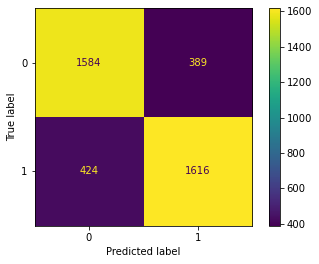

In [120]:
prediction, accuracy, precision, recall, f1 = decision_tree_scores(training_data, training_labels, testing_data, testing_labels)
print("Decision tree accuracy measure: ", accuracy * 100, "%")
print("Decision tree precision measure: ", precision * 100, "%")
print("Decision tree recall measure: ", recall * 100, "%")
print("Decision tree f1 measure: ", f1 * 100, "%")

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(testing_labels, prediction))
disp.plot()
plt.show()


## b) Na¨ıve Bayes

Na¨ıve bayes accuracy measure:  65.21305756292051 %
Na¨ıve bayes precision measure:  70.56458447331124 %
Na¨ıve bayes recall measure:  65.21305756292051 %
Na¨ıve bayes f1 measure:  63.06375264614563 %


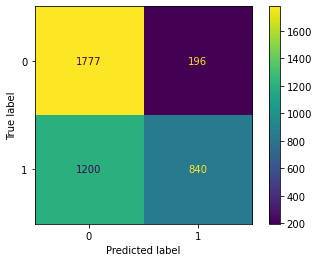

In [121]:
prediction, accuracy, precision, recall, f1 = naive_bayes_scores(training_data, training_labels, testing_data, testing_labels)
print("Na¨ıve bayes accuracy measure: ", accuracy * 100, "%")
print("Na¨ıve bayes precision measure: ", precision * 100, "%")
print("Na¨ıve bayes recall measure: ", recall * 100, "%")
print("Na¨ıve bayes f1 measure: ", f1 * 100, "%")

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(testing_labels, prediction))
disp.plot()
plt.show()

## c) K-NN

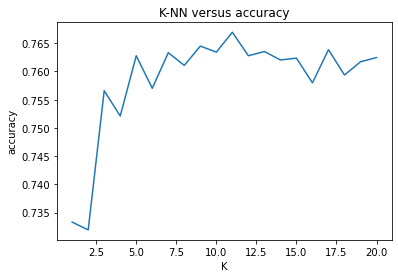

11-NN accuracy measure:  76.72564166459009 %
11-NN precision measure:  77.54932941570534 %
11-NN recall measure:  76.72564166459009 %
11-NN accuracy measure:  76.59618515224575 %


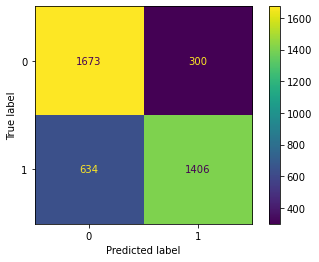

In [125]:
k_neighb = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
prediction, best_k_neighb, accuracy, precision, recall, f1 = knn_cross_val_scores(training_data, training_labels, testing_data, testing_labels, k_neighb, num_of_folds, scoring_method)
print(str(best_k_neighb) + "-NN accuracy measure: ", accuracy * 100, "%")
print(str(best_k_neighb) + "-NN precision measure: ", precision * 100, "%")
print(str(best_k_neighb) + "-NN recall measure: ", recall * 100, "%")
print(str(best_k_neighb) + "-NN accuracy measure: ", f1 * 100, "%")

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(testing_labels, prediction))
disp.plot()
plt.show()

## d) Ada Boost

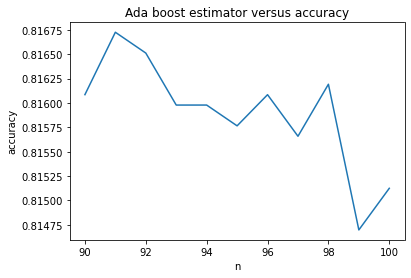

91_estimators AdaBoost accuracy measure:  82.63144779466734 %
91_estimators AdaBoost precision measure:  82.66602366600745 %
91_estimators AdaBoost recall measure:  82.63144779466734 %
91_estimators AdaBoost f1 measure:  82.63206255077384 %


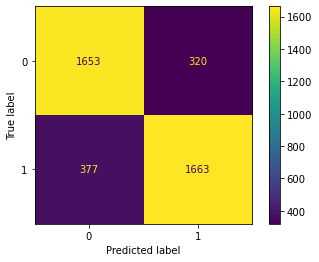

In [126]:
n_estimators = [90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]
prediction, best_n_estimator, accuracy, precision, recall, f1 = ada_boost_cross_val_scores(training_data, training_labels, testing_data, testing_labels, n_estimators, num_of_folds, scoring_method)
print(str(best_n_estimator) + "_estimators AdaBoost accuracy measure: ", accuracy * 100, "%")
print(str(best_n_estimator) + "_estimators AdaBoost precision measure: ", precision * 100, "%")
print(str(best_n_estimator) + "_estimators AdaBoost recall measure: ", recall * 100, "%")
print(str(best_n_estimator) + "_estimators AdaBoost f1 measure: ", f1 * 100, "%")

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(testing_labels, prediction))
disp.plot()
plt.show()

## e) Random Forests

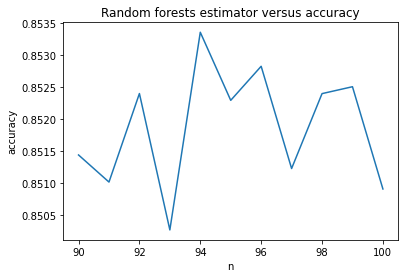

94_estimators random forests accuracy measure:  86.81784201345627 %
94_estimators random forests precision measure:  86.96528526612474 %
94_estimators random forests recall measure:  86.81784201345627 %
94_estimators random forests f1 measure:  86.81249260243317 %


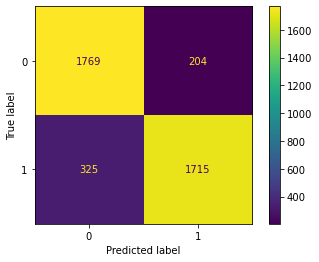

In [127]:
n_estimators = [90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]
prediction, best_n_estimator, accuracy, precision, recall, f1 = random_forests_cross_val_scores(training_data, training_labels, testing_data, testing_labels, n_estimators, num_of_folds, scoring_method)
print(str(best_n_estimator) + "_estimators random forests accuracy measure: ", accuracy * 100, "%")
print(str(best_n_estimator) + "_estimators random forests precision measure: ", precision * 100, "%")
print(str(best_n_estimator) + "_estimators random forests recall measure: ", recall * 100, "%")
print(str(best_n_estimator) + "_estimators random forests f1 measure: ", f1 * 100, "%")

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(testing_labels, prediction))
disp.plot()
plt.show()

# 6. Bonus

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn import preprocessing

In [23]:
EPOCHS = 2000

In [24]:
le = preprocessing.LabelEncoder()
training_encoded_labels = le.fit_transform(training_labels)
testing_encoded_labels = le.fit_transform(testing_labels)

In [25]:
print(f'Training Data Shape {training_data.shape}')
print(f'Training Label Shape {training_encoded_labels.shape}')

Training Data Shape (13314, 10)
Training Label Shape (13314,)


In [26]:
print(f'Training Data  {training_data[0]}')
print(f'Training Label {training_encoded_labels[0]}')

Training Data  [8.27097e+01 3.30359e+01 3.71440e+00 1.63300e-01 8.46000e-02 2.95431e+01
 6.10629e+01 1.90000e+01 1.21600e+00 2.91139e+02]
Training Label 0


In [27]:
X_train_val = torch.from_numpy(training_data).float()
X_test = torch.from_numpy(testing_data).float()
y_train_val = torch.from_numpy(training_encoded_labels).float()
y_test = torch.from_numpy(testing_encoded_labels).float()

In [28]:
print(X_train_val.shape)
print(X_test.shape)

torch.Size([13314, 10])
torch.Size([5706, 10])


In [29]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1, random_state=42) 

In [30]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

torch.Size([11982, 10])
torch.Size([1332, 10])
torch.Size([5706, 10])


In [31]:
class ClassificationModel(nn.Module):
    def __init__(self, input_layer, hidden_layer_1, hidden_layer_2, output_layer):
        super(ClassificationModel, self).__init__()
        self.l1 = nn.Linear(input_layer, hidden_layer_1)
        self.l2 = nn.Linear(hidden_layer_1, hidden_layer_2)
        self.out = nn.Linear(hidden_layer_2, output_layer)
 
    def forward(self, data):
        x = self.l1(data)
        x = torch.relu(x)
        x = self.l2(x)
        x = torch.relu(x)
        x = self.out(x)
        return torch.sigmoid(x)
     


In [32]:

def train_eval_model(model, epochs, optimizer, loss_fn, X_train, X_val, y_train, y_val, cross_val=False):
    acc_data_val = []
    acc_data_train = []
    loss_data_val = []
    loss_data_train = []

    for epoch in range(epochs+1):
        optimizer.zero_grad()
        model.train()
        y_pred_train = model(X_train)
        loss_train = loss_fn(y_pred_train, y_train)
        loss_train.backward()
        optimizer.step()

        model.eval()
        y_pred_val = model(X_val)
        loss_val = loss_fn(y_pred_val, y_val)
        condition = y_pred_val >= 0.5
        y_pred_val = torch.where(condition, 1, 0)
        val_acc = torch.sum(y_pred_val == y_val) / len(y_val)

        condition = y_pred_train >= 0.5
        y_pred_train = torch.where(condition, 1, 0)
        train_acc = torch.sum(y_pred_train == y_train) / len(y_train)
        if epoch % 250 == 0 and not cross_val:
            print(f'{epoch} : Training loss {loss_train} && Training Acc is {train_acc} || Val loss {loss_val} && Val Acc is {val_acc}')
        acc_data_val.append(val_acc)
        acc_data_train.append(train_acc)
        loss_data_val.append(loss_val.detach().numpy())
        loss_data_train.append(loss_train.detach().numpy())

    return np.array(acc_data_train), np.array(acc_data_val), np.array(loss_data_train), np.array(loss_data_val)
            

In [33]:
model_1 = ClassificationModel(10, 16, 32, 1)
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model_1.parameters(), lr=1e-4)
acc_data_train_1, acc_data_val_1, loss_data_train_1, loss_data_val_1 = train_eval_model(model_1, 2000, optimizer, loss_fn, X_train, X_val, y_train.reshape(-1, 1), y_val.reshape(-1, 1))

0 : Training loss 0.8336156606674194 && Training Acc is 0.7001335620880127 || Val loss 0.8687984943389893 && Val Acc is 0.695195198059082
250 : Training loss 0.5321425199508667 && Training Acc is 0.7283425331115723 || Val loss 0.5495922565460205 && Val Acc is 0.7147147059440613
500 : Training loss 0.5089632868766785 && Training Acc is 0.7423635721206665 || Val loss 0.53044593334198 && Val Acc is 0.7237237095832825
750 : Training loss 0.4953991174697876 && Training Acc is 0.7505424618721008 || Val loss 0.5191294550895691 && Val Acc is 0.7312312126159668
1000 : Training loss 0.48213016986846924 && Training Acc is 0.7627274394035339 || Val loss 0.5065453052520752 && Val Acc is 0.7409909963607788
1250 : Training loss 0.4650450646877289 && Training Acc is 0.7808379530906677 || Val loss 0.48884499073028564 && Val Acc is 0.7635135054588318
1500 : Training loss 0.44916021823883057 && Training Acc is 0.7971123456954956 || Val loss 0.47095394134521484 && Val Acc is 0.7755255103111267
1750 : Trai

In [34]:
model_2 = ClassificationModel(10, 64, 128, 1)
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model_2.parameters(), lr=1e-4)
acc_data_train_2, acc_data_val_2, loss_data_train_2, loss_data_val_2 = train_eval_model(model_2, 2000, optimizer, loss_fn, X_train, X_val, y_train.reshape(-1, 1), y_val.reshape(-1, 1))

0 : Training loss 7.443737030029297 && Training Acc is 0.3486062288284302 || Val loss 6.734973430633545 && Val Acc is 0.3611111044883728
250 : Training loss 0.48280733823776245 && Training Acc is 0.768903374671936 || Val loss 0.5050297379493713 && Val Acc is 0.7462462186813354
500 : Training loss 0.4532567858695984 && Training Acc is 0.7891837954521179 || Val loss 0.4816310703754425 && Val Acc is 0.7635135054588318
750 : Training loss 0.43175265192985535 && Training Acc is 0.8030378818511963 || Val loss 0.46493345499038696 && Val Acc is 0.7792792916297913
1000 : Training loss 0.4135574996471405 && Training Acc is 0.8143882751464844 || Val loss 0.45140519738197327 && Val Acc is 0.7860360145568848
1250 : Training loss 0.396808922290802 && Training Acc is 0.8231514096260071 || Val loss 0.4395972788333893 && Val Acc is 0.8003003001213074
1500 : Training loss 0.3821979761123657 && Training Acc is 0.8325822353363037 || Val loss 0.43041422963142395 && Val Acc is 0.8063063025474548
1750 : Trai

In [35]:
model_3 = ClassificationModel(10, 128, 512, 1)
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model_3.parameters(), lr=1e-4)
acc_data_train_3, acc_data_val_3, loss_data_train_3, loss_data_val_3 = train_eval_model(model_3, 2000, optimizer, loss_fn, X_train, X_val, y_train.reshape(-1, 1), y_val.reshape(-1, 1))

0 : Training loss 3.3785147666931152 && Training Acc is 0.3508596122264862 || Val loss 2.3269126415252686 && Val Acc is 0.3558558523654938
250 : Training loss 0.4440893232822418 && Training Acc is 0.7965281009674072 || Val loss 0.47389551997184753 && Val Acc is 0.7702702879905701
500 : Training loss 0.402678519487381 && Training Acc is 0.8220664262771606 || Val loss 0.4413677155971527 && Val Acc is 0.7905405163764954
750 : Training loss 0.37163713574409485 && Training Acc is 0.8385912179946899 || Val loss 0.4240533411502838 && Val Acc is 0.8063063025474548
1000 : Training loss 0.34947407245635986 && Training Acc is 0.8500250577926636 || Val loss 0.4170480966567993 && Val Acc is 0.8123123049736023
1250 : Training loss 0.33529338240623474 && Training Acc is 0.8543648719787598 || Val loss 0.41808560490608215 && Val Acc is 0.8183183073997498
1500 : Training loss 0.3251115083694458 && Training Acc is 0.8590385317802429 || Val loss 0.4262846112251282 && Val Acc is 0.8168168067932129
1750 : T

In [36]:
def plot_acc_loss(acc_data_train, acc_data_val, loss_data_train, loss_data_val):
    x_axis = range(0, EPOCHS+1)
    fig, axs = plt.subplots(1, 2, figsize=[18, 5])
    
    axs[0].plot(x_axis, acc_data_train, '--', color="r",  label="Training score")
    axs[0].plot(x_axis, acc_data_val, color="b", label="Cross-validation score")
    axs[0].set_title("Accuracy Curve")
    axs[0].set_xlabel("Training Set Size")
    axs[0].set_ylabel("Accuracy Score"), plt.legend(loc="best")
    axs[0].legend()
    
    axs[1].plot(x_axis, loss_data_train, '--', color="r",  label="Training loss")
    axs[1].plot(x_axis, loss_data_val, color="b", label="Cross-validation loss")
    axs[1].set_title("Loss Curve")
    axs[1].set_xlabel("Training Set Size")
    axs[1].set_ylabel("Loss Score"), plt.legend(loc="best")
    axs[1].legend()
    plt.show()

No handles with labels found to put in legend.


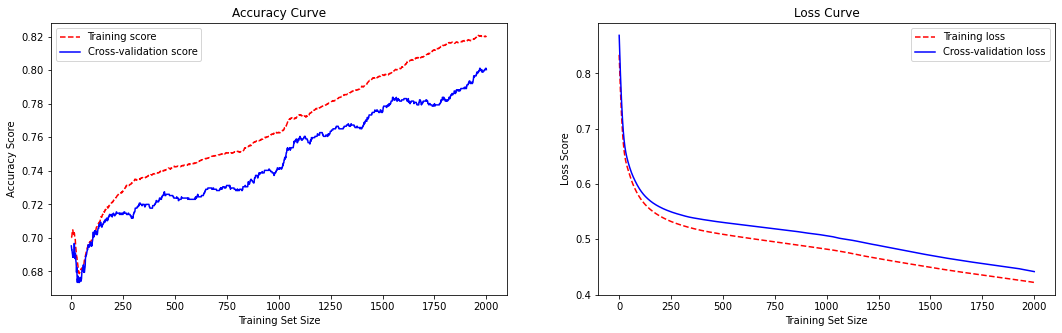

In [37]:
plot_acc_loss(acc_data_train_1, acc_data_val_1, loss_data_train_1, loss_data_val_1)

No handles with labels found to put in legend.


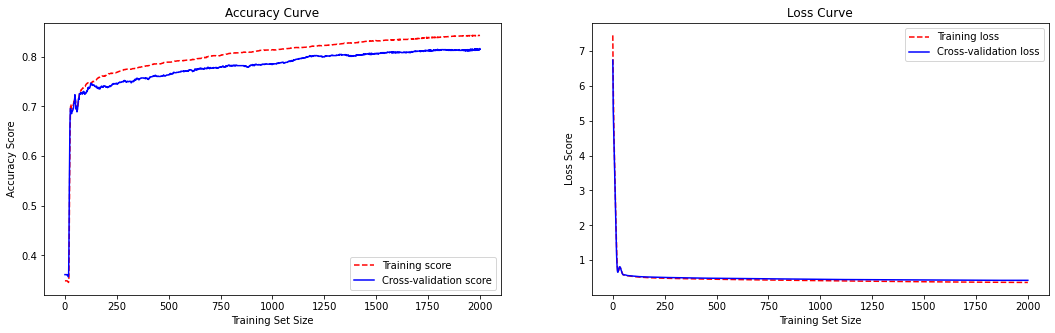

In [38]:
plot_acc_loss(acc_data_train_2, acc_data_val_2, loss_data_train_2, loss_data_val_2)

No handles with labels found to put in legend.


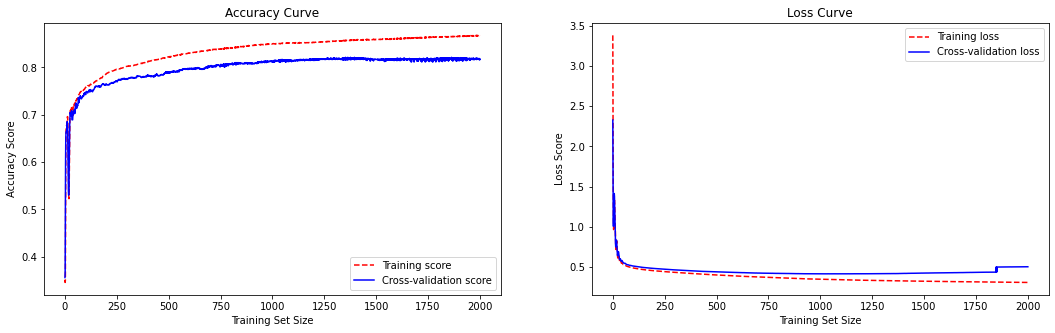

In [39]:
plot_acc_loss(acc_data_train_3, acc_data_val_3, loss_data_train_3, loss_data_val_3)

In [40]:
def evalute_test(model, X_test, y_test):
    model.eval()
    y_pred_test = model(X_test)
    cond = y_pred_test >= 0.5
    y_pred_test = torch.where(cond, 1, 0)
    train_acc = torch.sum(y_pred_test == y_test) / len(y_test)
    print(f"Model Acc. on Test Data {train_acc}")

In [41]:
evalute_test(model_1, X_test, y_test.reshape(-1, 1))
evalute_test(model_2, X_test, y_test.reshape(-1, 1))
evalute_test(model_3, X_test, y_test.reshape(-1, 1))

Model Acc. on Test Data 0.8101997971534729
Model Acc. on Test Data 0.8322818279266357
Model Acc. on Test Data 0.8305292725563049


In [42]:
y_list = torch.chunk(y_train_val, 10)
x_list = torch.chunk(X_train_val, 10)

In [43]:
x_list[0].shape

torch.Size([1332, 10])

In [44]:
def get_val_train(data, ind):
    val = data[ind]
    train = torch.Tensor()
    for i in range(len(data)):
        if i != ind:
            train = torch.cat((train, data[i]), dim=0)

    return train, val

In [45]:
param = [
    [16, 32],
    [32, 64],
    [64, 128],
    [128, 256],
    [256, 512],
]

In [51]:
def kfold(param, x_list, y_list, k, ephocs):
    best_loss_val = float('inf')
    best_acc_val = 0
    best_acc_train = 0
    best_loss_train = 0
    best_model = None
    for p in param:
        model =  ClassificationModel(10, p[0], p[1], 1)
        loss_fn = nn.BCELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
        total_loss_val = 0
        total_loss_train = 0
        total_acc_val = 0
        total_acc_train = 0
        for i in range(k):
            x_t, x_v = get_val_train(x_list, i)
            y_t, y_v = get_val_train(y_list, i)
            acc_data_train, acc_data_val, loss_data_train, loss_data_val = train_eval_model(model, ephocs, optimizer, loss_fn, x_t, x_v, y_t.reshape(-1, 1), y_v.reshape(-1, 1), cross_val=True)
            total_loss_train += np.sum(loss_data_train, axis=0) / ephocs
            total_loss_val += np.sum(loss_data_val, axis=0) / ephocs
            total_acc_train += np.sum(acc_data_train, axis=0) / ephocs
            total_acc_val += np.sum(acc_data_val, axis=0) / ephocs
        print(f'Using {p[0]},{p[1]} Training loss {total_loss_train / k} && Training Acc  {total_acc_val / k} || Val loss {total_loss_val / k} && Val Acc {total_acc_val / k}')
        if best_loss_val > total_loss_val / k:
            best_model = model
            best_loss_val = total_loss_val / k
            best_acc_val = total_acc_val / k
            best_loss_train = total_loss_train / k
            best_acc_train = total_acc_train / k
    return best_model, best_acc_train, best_loss_train, best_acc_val, best_loss_val


In [52]:
bestm, best_acc_train, best_loss_train, best_acc_val, best_loss_val = kfold(param, x_list, y_list, 10, 2000)

Using 16,32 Training loss 0.5890575775146484 && Training Acc  0.7614491638183594 || Val loss 0.5732836181640625 && Val Acc 0.7614491638183594
Using 32,64 Training loss 0.46378628234863284 && Training Acc  0.7984579956054688 || Val loss 0.4706030426025391 && Val Acc 0.7984579956054688
Using 64,128 Training loss 0.4221237121582031 && Training Acc  0.8095386047363281 || Val loss 0.4346036071777344 && Val Acc 0.8095386047363281
Using 128,256 Training loss 0.34709596557617184 && Training Acc  0.8370827453613281 || Val loss 0.3670499572753906 && Val Acc 0.8370827453613281
Using 256,512 Training loss 0.30260133056640626 && Training Acc  0.855128662109375 || Val loss 0.33175045776367185 && Val Acc 0.855128662109375


In [53]:
print(f'Best Model parameters :  {bestm.parameters}')

Best Model parameters :  <bound method Module.parameters of ClassificationModel(
  (l1): Linear(in_features=10, out_features=256, bias=True)
  (l2): Linear(in_features=256, out_features=512, bias=True)
  (out): Linear(in_features=512, out_features=1, bias=True)
)>


In [54]:
evalute_test(bestm, X_test, y_test.reshape(-1, 1))

Model Acc. on Test Data 0.8284262418746948


### Scaling Data